# Toy example to demonstrate the use of **mescal**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from mescal import *
import bw2data as bd
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
ei_version = '3.10.1'

In [4]:
# AMPL licence
path_to_ampl_licence = r'C:\Users\matth\ampl' # Path to the AMPL license file
os.environ['PATH'] = path_to_ampl_licence+':'+os.environ['PATH']

In [5]:
path_model = './data/esm/' # Path to the energy system model
path_model_lca = './data/esm/lca/'
path_inputs = './data/lca/' # Path to the LCA data
path_results = './results/' # Path to the results

## Generating LCA impact scores

In [6]:
mapping = pd.read_csv(path_inputs+'mapping.csv')
unit_conversion = pd.read_excel(path_inputs+'unit_conversion.xlsx')
techno_compositions = pd.read_csv(path_inputs+'technology_compositions.csv')
efficiency = pd.read_csv(path_inputs+'efficiency.csv')
lifetime = pd.read_csv(path_inputs+'lifetime.csv')
mapping_es_flows_to_cpc = pd.read_csv(path_inputs+'mapping_esm_flows_to_CPC.csv')
impact_abbrev = pd.read_csv(path_inputs+'impact_abbrev.csv')
model = pd.read_csv(path_inputs+'model.csv')

In [7]:
# Set up your Brightway project
bd.projects.set_current(f'ecoinvent{ei_version}')

In [8]:
name_main_database = f'ecoinvent_cutoff_{ei_version}_image_SSP2-Base_2050'

In [ ]:
main_db = Database(name_main_database, create_pickle=True)

In [ ]:
# Add CPC categories to the main database
main_db.add_CPC_categories()

In [ ]:
ranking_best_ecoinvent_locations = ['GLO', 'RoW']

In [ ]:
esm = ESM(
    # Mandatory inputs
    mapping=mapping,
    unit_conversion=unit_conversion,
    model=model,
    mapping_esm_flows_to_CPC_cat=mapping_es_flows_to_cpc,
    main_database=main_db,
    esm_db_name='Tatooine_2050',

    # Optional inputs
    technology_compositions=techno_compositions,
    lifetime=lifetime,
    efficiency=efficiency,
    regionalize_foregrounds=False,
    locations_ranking=ranking_best_ecoinvent_locations,
    esm_location='GLO',
    results_path_file=path_results,
)

In [ ]:
esm.check_inputs()

In [ ]:
# Adapt mapping file to ESM location
esm.change_location_mapping_file()
# esm.mapping.to_csv(path_inputs+f'mapping.csv', index=False)

In [ ]:
missing_flows = main_db.test_mapping_file(esm.mapping)

In [ ]:
esm.create_esm_database()

In [ ]:
# Save the mapping file with new codes for later use
esm.mapping.to_csv(path_results+'mapping_with_new_codes.csv', index=False)

In [ ]:
methods = ['IMPACT World+ Midpoint 2.1_regionalized for ecoinvent v3.10', 'IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10']

In [ ]:
R_long = esm.compute_impact_scores(
    methods=methods,
    impact_abbrev=impact_abbrev,
)

In [ ]:
R_long.to_csv(f'{path_results}impact_scores.csv', index=False) # [impact / kW(h) or pkm(/h) or tkm(/h)]

In [ ]:
activities_subject_to_double_counting = pd.read_csv(f'{path_results}activities_subject_to_double_counting.csv')

In [ ]:
R_long_direct_emissions = esm.compute_impact_scores(
    methods=methods,
    assessment_type='direct emissions',
    impact_abbrev=impact_abbrev,
    activities_subject_to_double_counting=activities_subject_to_double_counting,
    overwrite=True,
)

In [ ]:
R_long_direct_emissions.to_csv(f'{path_results}impact_scores_direct_emissions.csv', index=False) # [impact / kW(h) or pkm(/h) or tkm(/h)]

In [ ]:
metadata = {
    'ecoinvent_version': ei_version,
    'year': '2050',
    'iam': 'image',
    'ssp_rcp': 'SSP2-Base',
}

In [ ]:
specific_lcia_abbrev = ['m_CCS', 'TTHH', 'TTEQ']

In [ ]:
# Create .dat file
esm.normalize_lca_metrics(
    R=R_long,
    mip_gap=1e-6,
    lcia_methods=methods,
    specific_lcia_abbrev=specific_lcia_abbrev,
    impact_abbrev=impact_abbrev,
    path=path_model_lca,
    metadata=metadata,
    file_name='techs_lca',
)

In [ ]:
# Create .dat file for direct emissions only
esm.normalize_lca_metrics(
    assessment_type='direct emissions',
    R=R_long_direct_emissions,
    max_per_cat=pd.read_csv(path_model_lca + 'techs_lca_max.csv'),
    mip_gap=1e-6,
    lcia_methods=methods,
    specific_lcia_abbrev=specific_lcia_abbrev,
    impact_abbrev=impact_abbrev,
    path=path_model_lca,
    metadata=metadata,
    file_name='techs_lca_direct',
)

In [ ]:
# Create the .mod file
esm.generate_mod_file_ampl(
    lcia_methods=methods,
    impact_abbrev=impact_abbrev,
    specific_lcia_abbrev=specific_lcia_abbrev,
    path=path_model_lca,
    metadata=metadata,
    file_name='objectives_lca',
)

In [ ]:
# Create the .mod file for direct emissions only
esm.generate_mod_file_ampl(
    assessment_type='direct emissions',
    lcia_methods=methods,
    impact_abbrev=impact_abbrev,
    specific_lcia_abbrev=specific_lcia_abbrev,
    path=path_model_lca,
    metadata=metadata,
    file_name='objectives_lca_direct',
)

## Running the ESM

In [6]:
max_per_cat = pd.read_csv(path_model_lca + 'techs_lca_max.csv')
impact_scores = pd.read_csv(path_results+'impact_scores.csv')

In [7]:
max_ccs = max_per_cat[max_per_cat['Abbrev'] == 'm_CCS']['max_AoP'].values[0]
max_tthh = max_per_cat[max_per_cat['Abbrev'] == 'TTHH']['max_AoP'].values[0]
max_tteq = max_per_cat[max_per_cat['Abbrev'] == 'TTEQ']['max_AoP'].values[0]

### Single objective optimization

In [8]:
list_esm_results_f_mult = []
list_esm_results_annual_res = []
list_esm_results_annual_prod = []
list_main_variables_results = []

for obj in ['TotalCost', 'TotalLCIA_m_CCS', 'TotalLCIA_TTHH', 'TotalLCIA_TTEQ']:

    results = run_esm(obj)

    df_f_mult, df_annual_prod, df_annual_res = get_impact_scores(
        df_results=results,
        df_impact_scores=impact_scores,
        impact_category=[
            ('IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10', 'Human health', 'Total human health'),
            ('IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10', 'Ecosystem quality', 'Total ecosystem quality'),
            ('IMPACT World+ Midpoint 2.1_regionalized for ecoinvent v3.10', 'Midpoint', 'Climate change, short term'),
        ]
    )

    df_f_mult['Run'] = obj
    df_annual_prod['Run'] = obj
    df_annual_res['Run'] = obj

    df_f_mult.rename(columns={'index': 'Name'}, inplace=True)
    df_annual_prod.rename(columns={'index': 'Name'}, inplace=True)
    df_annual_res.rename(columns={'index': 'Name'}, inplace=True)

    total_cost = results.variables['TotalCost'].TotalCost.values[0]
    total_m_ccs = results.variables['TotalLCIA_m_CCS'].TotalLCIA_m_CCS.values[0]
    total_tthh = results.variables['TotalLCIA_TTHH'].TotalLCIA_TTHH.values[0]
    total_tteq = results.variables['TotalLCIA_TTEQ'].TotalLCIA_TTEQ.values[0]

    list_main_variables_results.append([obj, total_cost, total_m_ccs, total_tthh, total_tteq])

    list_esm_results_f_mult.append(df_f_mult)
    list_esm_results_annual_prod.append(df_annual_prod)
    list_esm_results_annual_res.append(df_annual_res)

esm_results_f_mult = pd.concat(list_esm_results_f_mult)
esm_results_annual_prod = pd.concat(list_esm_results_annual_prod)
esm_results_annual_res = pd.concat(list_esm_results_annual_res)
main_variables_results = pd.DataFrame(data=list_main_variables_results, columns=['Objective', 'TotalCost', 'TotalLCIA_m_CCS', 'TotalLCIA_TTHH', 'TotalLCIA_TTEQ'])

Gurobi 12.0.0: 

In [9]:
main_variables_results

,Objective,TotalCost,TotalLCIA_m_CCS,TotalLCIA_TTHH,TotalLCIA_TTEQ
0,TotalCost,362.101013,762.764789,761.468102,1006.340858
1,TotalLCIA_m_CCS,418.712941,199.595268,245.642999,701.840665
2,TotalLCIA_TTHH,621.397177,202.214934,236.509829,457.772084
3,TotalLCIA_TTEQ,761.720826,219.973407,245.119378,310.994264


In [14]:
# lyrio = results.parameters['layers_in_out'].reset_index()
# lyrio = lyrio[lyrio.layers_in_out != 0].drop(columns=['Run']).rename({'index0': 'Name', 'index1': 'Flow', 'layers_in_out': 'Amount'}, axis=1)
# lyrio.to_csv(path_inputs+'model.csv', index=False)

### Multi-objective optimization

#### Pareto front

In [69]:
# normalized limit = (physical limit [impact / cap] / max_AoP) * N_cap
N_run = 300
obj1 = 'TotalLCIA_m_CCS'
max_obj1 = max_ccs
obj2 = 'TotalCost'
max_obj2 = 1

normalized_limits_list = []
obj1_min = main_variables_results[main_variables_results['Objective'] == obj1][obj1].values[0]
obj1_max = main_variables_results[main_variables_results['Objective'] == obj2][obj1].values[0]
physical_limit_list = list(np.linspace(obj1_min, obj1_max, N_run))
# physical_limit_list = list(np.logspace(np.log10(688.41), np.log10(750), N_run))
for limit in physical_limit_list:
        normalized_limits_list.append((limit / max_obj1))

In [70]:
data = ['limit_lcia', obj1.split('TotalLCIA_')[-1], None, None, None] + normalized_limits_list
columns = ['param', 'index0', 'index1', 'index2', 'index3'] + [f'value{i+1}' for i in range(N_run)]

In [71]:
seq_data = pd.DataFrame(data).T
seq_data.columns = columns

In [72]:
es = run_esm(objective_function=obj2, returns='model')

In [73]:
results_pareto = es.calc_sequence(seq_data)

Gurobi 12.0.0: 1
Gurobi 12.0.0: 2
Gurobi 12.0.0: 3
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.7440767971523924e-16;"
will change deduced dual values.

4
Gurobi 12.0.0: 5
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.712643449816542e-16;"
will change deduced dual values.

6
Gurobi 12.0.0: 7
Gurobi 12.0.0: 8
Gurobi 12.0.0: 9
Gurobi 12.0.0: 10
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.6388034144663154e-16;"
will change deduced dual values.

11
Gurobi 12.0.0: 12
Gurobi 12.0.0: 13
Gurobi 12.0.0: 14
Gurobi 12.0.0: 15
Gurobi 12.0.0: 16
Gurobi 12.0.0: 17
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.545515306632984e-16;"
will change deduced dual values.

18
Gurobi 12.0.0: 19
Gurobi 12.0.0: 20
Gurobi 12.0.0: 21
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.4968260973023003e-16;"
will ch

In [74]:
results_pareto = postprocessing(results_pareto)

#### Sobol sequence

In [56]:
from energyscope.datasets import gen_sobol_sequence

In [57]:
parameters = [
    {
        'name': cat,
        'lower_bound': main_variables_results[f'TotalLCIA_{cat}'].min(),
        'upper_bound': main_variables_results[f'TotalLCIA_{cat}'].max()
    }
    for cat in ['TTHH', 'TTEQ']
]

In [58]:
seq, prob = gen_sobol_sequence(parameters=parameters, trajectories=128)

In [59]:
seq_df = pd.DataFrame(seq, columns=prob['names']).T
seq_df.columns = ['value' + str(x) for x in list(seq_df.columns) if not str(x) == "nan"]
seq_df = seq_df.reset_index(names=['index0'])
seq_df['param'] = ['limit_lcia'] * len(seq_df)

seq_df['index1'] = np.nan
seq_df['index2'] = np.nan
seq_df['index3'] = np.nan

In [60]:
es = run_esm(objective_function='TotalCost', returns='model')

In [61]:
results_sobol = es.calc_sequence(seq_df)

Gurobi 12.0.0: 
"option abs_boundtol 2.842170943040401e-14;"
or "option rel_boundtol 1.1712483422282956e-16;"
will change deduced dual values.

1
Gurobi 12.0.0: 2
Gurobi 12.0.0: 
"option abs_boundtol 2.842170943040401e-14;"
or "option rel_boundtol 1.1712483422282956e-16;"
will change deduced dual values.

3
Gurobi 12.0.0: 4
Gurobi 12.0.0: 5
Gurobi 12.0.0: 6
Gurobi 12.0.0: 7
Gurobi 12.0.0: 8
Gurobi 12.0.0: 9
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 2.1941621350700717e-16;"
will change deduced dual values.

10
Gurobi 12.0.0: 11
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 2.1941621350700717e-16;"
will change deduced dual values.

12
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.5202789132657003e-16;"
will change deduced dual values.

13
Gurobi 12.0.0: 14
Gurobi 12.0.0: 
"option abs_boundtol 5.684341886080802e-14;"
or "option rel_boundtol 1.5202789132657003e-16;"
wi

In [62]:
results_sobol = postprocessing(results_sobol)

## Visualize the results

In [33]:
tech_to_show_list = [i for i in impact_scores.Name.unique() if i not in ['GRID']]

### SOO

In [34]:
main_variables_results_norm = pd.DataFrame()
for col in main_variables_results.columns:
    if col != 'Objective':
        main_variables_results_norm[col] = main_variables_results[col] / main_variables_results[col].max()
    else:
        main_variables_results_norm['Objective function'] = main_variables_results[col]

In [35]:
main_variables_results_norm.rename(columns=obj_name_dict, inplace=True)
main_variables_results_norm['Objective function'] = main_variables_results_norm['Objective function'].apply(lambda x: obj_name_dict[x])

In [36]:
main_variables_results_norm = main_variables_results_norm.melt(id_vars=['Objective function'], var_name='Indicator', value_name='Normalized indicator')

In [37]:
fig = px.bar(
    main_variables_results_norm,
    x='Objective function',
    y='Normalized indicator',
    color='Indicator',
    barmode='group',
)

fig.update_layout(template='plotly_white')

fig.show()

In [38]:
fig = px.bar(
    main_variables_results_norm,
    color='Objective function',
    y='Normalized indicator',
    x='Indicator',
    barmode='group',
)

fig.update_layout(template='plotly_white')

fig.show()

In [44]:
plot_technologies_contribution(
    cat='Total human health',
    esm_results_f_mult=esm_results_f_mult,
    esm_results_annual_prod=esm_results_annual_prod,
    esm_results_annual_res=esm_results_annual_res,
    tech_to_show_list=tech_to_show_list,
)

In [45]:
plot_technologies_contribution(
    cat='Total ecosystem quality',
    esm_results_f_mult=esm_results_f_mult,
    esm_results_annual_prod=esm_results_annual_prod,
    esm_results_annual_res=esm_results_annual_res,
    tech_to_show_list=tech_to_show_list,
)

In [46]:
plot_technologies_contribution(
    cat='Climate change, short term',
    esm_results_f_mult=esm_results_f_mult,
    esm_results_annual_prod=esm_results_annual_prod,
    esm_results_annual_res=esm_results_annual_res,
    tech_to_show_list=tech_to_show_list,
)

In [47]:
plot_technologies_contribution(
    cat='Total cost',
    esm_results_f_mult=esm_results_f_mult,
    esm_results_annual_prod=esm_results_annual_prod,
    esm_results_annual_res=esm_results_annual_res,
    tech_to_show_list=tech_to_show_list,
)

### MOO

#### Pareto front

In [82]:
colors_var = 'TotalLCIA_TTHH'
max_colors_var = max_tthh
add_soo_point = False

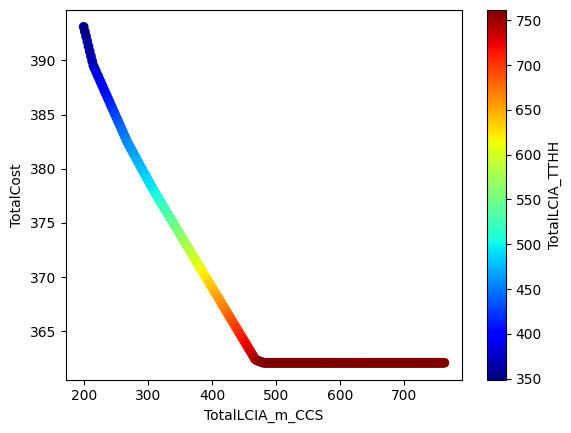

In [83]:
x = physical_limit_list
y = list(results_pareto.variables[obj2][obj2])
colors = list(results_pareto.variables[colors_var][colors_var])

# adding data point from colors_var SOO
if add_soo_point:
    x = x + [main_variables_results[main_variables_results['Objective'] == colors_var][obj1].values[0]]
    y = y + [main_variables_results[main_variables_results['Objective'] == colors_var][obj2].values[0]]
    colors = colors + [main_variables_results[main_variables_results['Objective'] == colors_var][colors_var].values[0]]

# Create the scatter plot
scatter = plt.scatter(x, y, c=colors, cmap='jet')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label(colors_var)

# Add labels and title
plt.xlabel(obj1)
plt.ylabel(obj2)

# Show the plot
plt.show()

#### Sobol sequence

In [65]:
def plot_heat_map_sobol(
        results_sobol,
        x_var: str,
        y_var: str,
        color_var: str,
        fill: bool,
):

    limit_lcia = results_sobol.parameters['limit_lcia']

    x=limit_lcia[limit_lcia.index == x_var].limit_lcia.tolist()
    y=limit_lcia[limit_lcia.index == y_var].limit_lcia.tolist()
    c=results_sobol.variables[color_var][color_var].tolist()

    if fill:
        plt.tricontourf(x, y, c, 128, cmap=plt.get_cmap('jet'))

    else:
        plt.scatter(
            x=limit_lcia[limit_lcia.index == x_var].limit_lcia.tolist(),
            y=limit_lcia[limit_lcia.index == y_var].limit_lcia.tolist(),
            c=results_sobol.variables[color_var][color_var].tolist(),
            cmap='jet',
        )

    # Add a colorbar
    cbar = plt.colorbar()
    cbar.set_label(color_var)

    plt.xlabel('Upper limit for ' + x_var)
    plt.ylabel('Upper limit for ' + y_var)

    plt.show()

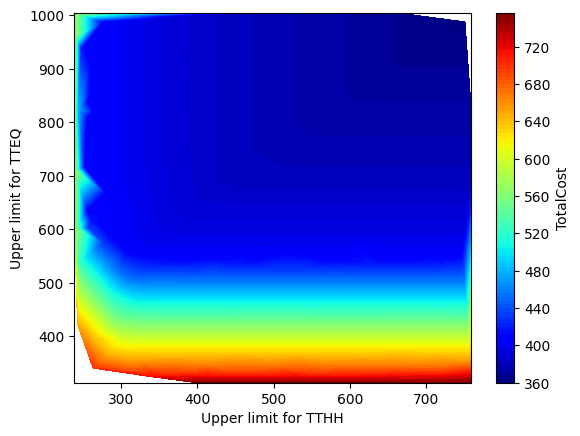

In [81]:
plot_heat_map_sobol(
    results_sobol=results_sobol,
    x_var = 'TTHH',
    y_var = 'TTEQ',
    color_var = 'TotalCost',
    fill=True,
)